In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re 
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, LSTM

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [26]:
with open('SMSSpamCollection','r') as file:
    text=file.read().lower()

text

'ham\tgo until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat...\nham\tok lar... joking wif u oni...\nspam\tfree entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question(std txt rate)t&c\'s apply 08452810075over18\'s\nham\tu dun say so early hor... u c already then say...\nham\tnah i don\'t think he goes to usf, he lives around here though\nspam\tfreemsg hey there darling it\'s been 3 week\'s now and no word back! i\'d like some fun you up for it still? tb ok! xxx std chgs to send, £1.50 to rcv\nham\teven my brother is not like to speak with me. they treat me like aids patent.\nham\tas per your request \'melle melle (oru minnaminunginte nurungu vettam)\' has been set as your callertune for all callers. press *9 to copy your friends callertune\nspam\twinner!! as a valued network customer you have been selected to receivea £900 prize reward! to claim call 09061701461. claim code kl341. v

In [27]:
x0=[]
y0=[]
for i in text.split('\n'):
    j=i.split('\t')
    y0.append(j[0])
    x0.append(j[1])

In [28]:
dict1={
    'message':x0,
    'output':y0
}
data=pd.DataFrame(dict1)

In [44]:
le = LabelEncoder()
le.fit(data["output"])
data["output_encoded"] = le.transform(data["output"])

output_classes = le.classes_.tolist()

In [30]:
data['output'].value_counts()

output
ham     4827
spam     747
Name: count, dtype: int64

In [31]:
x_train, x_test = train_test_split(data,test_size=0.25,random_state=10,shuffle=True,stratify=data["output"])
y_train = x_train["output_encoded"].to_numpy()
y_test = x_test["output_encoded"].to_numpy()

In [32]:
ps=PorterStemmer()
#refered online for this..
def pre_pro(some_string):
    
    # To match HTML/XML entities (e.g., &amp;, &lt;, etc.)
    review = re.sub(r"&amp|&lt|&gt|&quot;", "", some_string)

    # Remove URLs
    review = re.sub(r"https?://\S+|www\.\S+", "", review)

    # Keep only alphanumerics, hash tags, whitespace.
    review = re.sub(r"[^a-zA-Z0-9£$€¥₹\s]", " ", review)

    # Remove whitespaces and split into list
    review = " ".join(review.lower().strip().split())

    review = re.findall(r"\b\w+\b", review.lower())
    review=[ps.stem(word) for word in review if word not in stopwords.words('english')]
    review=" ".join(review)
    return review

In [33]:
x_train['message_cleaned']=x_train['message'].apply(pre_pro)
x_test['message_cleaned']=x_test['message'].apply(pre_pro)

In [34]:
x_train['output'].value_counts()

output
ham     3620
spam     560
Name: count, dtype: int64

In [35]:
x_train.head(10)

,message,output,output_encoded,message_cleaned
2219,nice talking to you! please dont forget my pix...,ham,0,nice talk pleas dont forget pix want see
376,can you say what happen,ham,0,say happen
4535,i have no money 4 steve mate! !,ham,0,money 4 steve mate
2374,xmas prize draws! we are trying to contact u. ...,spam,1,xma prize draw tri contact u today draw show 2...
2439,i not busy juz dun wan 2 go so early.. hee..,ham,0,busi juz dun wan 2 go earli hee
4247,well welp is sort of a semiobscure internet thing,ham,0,well welp sort semiobscur internet thing
4683,"haha yeah, 2 oz is kind of a shitload",ham,0,haha yeah 2 oz kind shitload
4040,i cant pick the phone right now. pls send a me...,ham,0,cant pick phone right pl send messag
3612,no. i.ll meet you in the library,ham,0,meet librari
1477,i'm watching lotr w my sis dis aft. so u wan 2...,ham,0,watch lotr w si di aft u wan 2 meet 4 dinner nite


In [36]:
tfv = TfidfVectorizer(
    max_df=0.95,
    min_df=0.01,
    ngram_range=(1, 4),
)
tfv.fit(x_train["message_cleaned"].values)

TfidfVectorizer(max_df=0.95, min_df=0.01, ngram_range=(1, 4))

In [37]:
tokenizer = Tokenizer(num_words=20000)

tokenizer.fit_on_texts(x_train["message_cleaned"])

x_train_tk = tokenizer.texts_to_sequences(x_train["message_cleaned"])
x_train_tk = pad_sequences(x_train_tk)

x_test_tk = tokenizer.texts_to_sequences(x_test["message_cleaned"])
x_test_tk = pad_sequences(x_test_tk, maxlen=x_train_tk.shape[1])

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input, Dropout

In [39]:
rnn = tf.keras.models.Sequential()

rnn.add(Input(shape=(x_train_tk.shape[1],)))
# Embed Layer
rnn.add(Embedding(len(tokenizer.word_index) + 1, 128))
# LSTMvLayer
rnn.add(LSTM(64))

#Output Layer
rnn.add(Dense(units=2, activation='softmax'))

In [40]:
# Compile the model
rnn.compile(
    optimizer="adam",
    loss="SparseCategoricalCrossentropy",
    metrics=["accuracy"],
)

# Print the model summary
rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 66, 128)        │       796,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 845,826 (3.23 MB)

 Trainable params: 845,826 (3.23 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
early_stopping = EarlyStopping(monitor="val_loss",patience=10,restore_best_weights=True)

In [42]:
history = rnn.fit(
    x_train_tk, y_train, epochs=100, batch_size=50,
    validation_split=0.2,
    callbacks=[early_stopping],
)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8958 - loss: 0.3301 - val_accuracy: 0.9833 - val_loss: 0.0677
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9891 - loss: 0.0499 - val_accuracy: 0.9904 - val_loss: 0.0376
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9963 - loss: 0.0155 - val_accuracy: 0.9880 - val_loss: 0.0451
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9987 - loss: 0.0085 - val_accuracy: 0.9904 - val_loss: 0.0436
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9996 - loss: 0.0014 - val_accuracy: 0.9904 - val_loss: 0.0413
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9916 - val_loss: 0.0377
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9998 - loss: 5.7952e-04 - val_accuracy: 0.9892 - val_loss: 0.0387
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 3.2727e-04 - val_accu

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1207
           1       0.99      0.93      0.96       187

    accuracy                           0.99      1394
   macro avg       0.99      0.96      0.98      1394
weighted avg       0.99      0.99      0.99      1394



Text(0.5, 0, 'Predicted values')

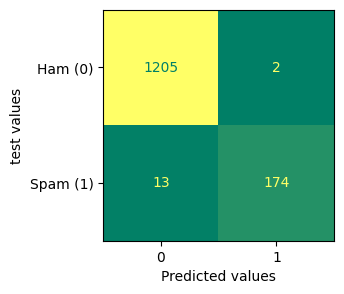

In [46]:
#got code from internet
import matplotlib.pyplot as plt
y_test_pred = np.argmax(rnn.predict(x_test_tk), axis=1)
print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[
        f"{label.capitalize().replace('_', ' ')} ({i})"
        for i, label in enumerate(output_classes)
    ],
)
disp.plot(ax=ax, cmap="summer", colorbar=False)
ax.set_xticklabels([i for i, _ in enumerate(output_classes)])
ax.grid(False)
ax.set_ylabel("test values")
ax.set_xlabel("Predicted values")
